In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pwd
!ls -al

/content
total 20
drwxr-xr-x 1 root root 4096 Aug 22 12:33 .
drwxr-xr-x 1 root root 4096 Aug 22 12:27 ..
drwxr-xr-x 1 root root 4096 Aug 20 16:13 .config
drwx------ 3 root root 4096 Aug 22 12:33 drive
drwxr-xr-x 1 root root 4096 Aug 20 16:13 sample_data


In [0]:
import os
os.chdir("drive/My Drive/Mask_RCNN")

In [0]:
!ls

assets	  images       mask_rcnn_balloon.h5  README.md		      setup.cfg
build	  LICENSE      mask_rcnn_coco.h5     requirements.txt	      setup.py
datasets  logs	       mask_rcnn.egg-info    run_bash_mask_cnn.ipynb
dist	  MANIFEST.in  mrcnn		     samples


In [0]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
# ROOT_DIR = os.path.abspath("../../")
ROOT_DIR = os.path.abspath("./")  # currnet directory
print(ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config_50 import Config   #######
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# directory of dataset 
DATASET_DIR = os.path.join(ROOT_DIR,"datasets/apples")
print(DATASET_DIR)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

/content/drive/My Drive/Mask_RCNN
/content/drive/My Drive/Mask_RCNN/datasets/apples


Using TensorFlow backend.


## Configurations

In [0]:
class FruitConfig(Config):
    """Configuration for training on the fruit dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "apple"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1   ####

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + fruit

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

config = FruitConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [0]:
### Override the training configurations with a few changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [0]:
### Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Dataset

In [0]:
import csv
import skimage.draw

class FruitDataset(utils.Dataset):
      def load_fruit(self, dataset_dir, subset):
          """Load a subset of the fruit dataset.
          dataset_dir: Root directory of the dataset.
          subset: Subset to load: train,val or test
          """
          # Add classes. We have only one class to add.
          self.add_class("apple", 1, "apple")

          # Train, validation or test dataset?
          assert subset in ["train", "val","test"]
          dataset_dir = os.path.join(dataset_dir, subset)
          print(dataset_dir)
          
          # Load annotations
          img_file_list=[]
          ano_file_list=[]
          for name in os.listdir(dataset_dir):
              if name.endswith(".png"):
                 img_file_list.append(name)
              elif name.endswith(".csv"):
                 ano_file_list.append(name)
          
       
          for name in img_file_list:
              index_=name.index("_")
              pre_name=name[:index_+3].strip()
#               print(pre_name)

#               try:
#                  ano_index=ano_file_list.index(pre_name)
#               except:
#                  continue
              
              if (pre_name+".csv") not in ano_file_list:
                  continue
                
              r_list=[]
              c_list=[]
              radius_list=[]
              ano_path=os.path.join(dataset_dir, pre_name+".csv")
              with open(ano_path) as f:  ####
                  f_csv=csv.reader(f)
                  headers=next(f_csv)
                  for row in f_csv:
                      r_list.append(row[2])  ##### subscript, row is y, column is x
                      c_list.append(row[1])
                      radius_list.append(row[3])
              
#               print("r_list:",r_list)
#               print("c_list:",c_list)
#               print("radius_list:",radius_list)
              
              image_path = os.path.join(dataset_dir, name)
              image = skimage.io.imread(image_path)
              height, width = image.shape[:2] 
#               print("height:",height,"width:",width)   # 202*308
              
              self.add_image(
                  "apple",
                  image_id=name,  # use file name as a unique image id
                  path=image_path,
                  width=width, height=height,
                  r=r_list,
                  c=c_list,
                  radius=radius_list)  ######
             
       
      def load_mask(self, image_id):
          """Generate instance masks for an image.
             Returns:
             masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
             class_ids: a 1D array of class IDs of the instance masks.
          """
          # If not a balloon dataset image, delegate to parent class.
          image_info = self.image_info[image_id]
          if image_info["source"] != "apple":
              return super(self.__class__, self).load_mask(image_id)

          # Convert circles to a bitmap mask of shape
          # [height, width, instance_count]
          info = self.image_info[image_id]
#           print("len(r):",len(info["r"]))
#           print(info["r"])
#           print(info["c"])
#           print(info["radius"])
          mask = np.zeros([info["height"], info["width"], len(info["r"])],
                          dtype=np.uint8)
#           print("mask_shape:",mask.shape)
#           index=0
          for index in range(len(info["r"])):
              # Get indexes of pixels inside the circle and set them to 1
#               print("r:",info["r"][index])
#               print("c:",info["c"][index])
#               print("radius:",info["radius"][index])
              rr, cc = skimage.draw.circle(float(info["r"][index]), float(info["c"][index]), float(info["radius"][index]),mask.shape)  
              mask[rr, cc, index] = 1

          # Return mask, and array of class IDs of each instance. Since we have
          # one class ID only, we return an array of 1s
          return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
          
      
      def image_reference(self, image_id):
          """Return the path of the image."""
          info = self.image_info[image_id]
          if info["source"] == "apple":
              return info["path"]
          else:
              super(self.__class__, self).image_reference(image_id)
      

In [0]:
### Load validation dataset
dataset_val = FruitDataset()
dataset_val.load_fruit(DATASET_DIR, "val")

# Must call before using the dataset
dataset_val.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

/content/drive/My Drive/Mask_RCNN/datasets/apples/val
Images: 112
Classes: ['BG', 'apple']


In [0]:
### Load test dataset
dataset_test = FruitDataset()
dataset_test.load_fruit(DATASET_DIR, "test")

# Must call before using the dataset
dataset_test.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_test.image_ids), dataset_test.class_names))

/content/drive/My Drive/Mask_RCNN/datasets/apples/test
Images: 112
Classes: ['BG', 'apple']


## Load Model

In [0]:
### Head Training Model, Create model object in inference mode.
with tf.device(DEVICE):
  model_head = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=inference_config)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = model.find_last()
model_head_path = os.path.join(ROOT_DIR+"/logs", "apple_50_head_epoch15_step100.h5")

# Load trained weights
print("Loading weights from ", model_head_path)
model_head.load_weights(model_head_path, by_name=True)

W0822 12:38:51.650044 139912115160960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 12:38:51.660797 139912115160960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 12:38:51.667603 139912115160960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0822 12:38:51.715266 139912115160960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0822 12:38:51.723041 139912115

Loading weights from  /content/drive/My Drive/Mask_RCNN/logs/apple_50_head_epoch15_step100.h5


In [0]:
### Create model object in inference mode.
with tf.device(DEVICE):
  model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=inference_config)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = model.find_last()
model_path = os.path.join(ROOT_DIR+"/logs", "apple_50_all_epoch25_step100.h5")

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/Mask_RCNN/logs/apple_50_all_epoch25_step100.h5


## Run Detection on Validation Dataset

image ID: apple.20130320T005805.533702.Cam6_13.png (83) /content/drive/My Drive/Mask_RCNN/datasets/apples/val/20130320T005805.533702.Cam6_13.png


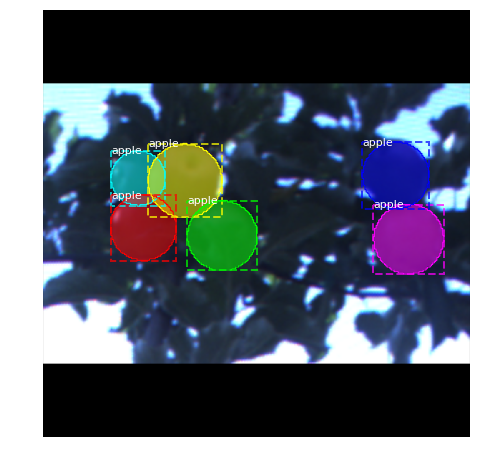

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (6,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (6, 4)                min:  162.00000  max:  962.00000  int32
gt_mask                  shape: (1024, 1024, 6)       min:    0.00000  max:    1.00000  bool


In [0]:
image_id = random.choice(dataset_val.image_ids)
image_id = 83  # 20130320T005805.533702.Cam6_13.png
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))

# ground truth
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))   ######## dataset_train.class_names

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


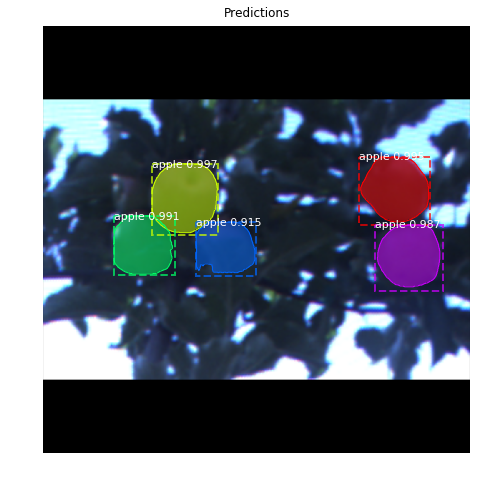

In [0]:
##### Head training model, Run object detection
results_head = model_head.detect([original_image], verbose=1)

# Display results
ax = get_ax(1)
r_head = results_head[0]
visualize.display_instances(original_image, r_head['rois'], r_head['masks'], r_head['class_ids'], 
                            dataset_val.class_names, r_head['scores'], ax=ax,
                            title="Predictions")

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


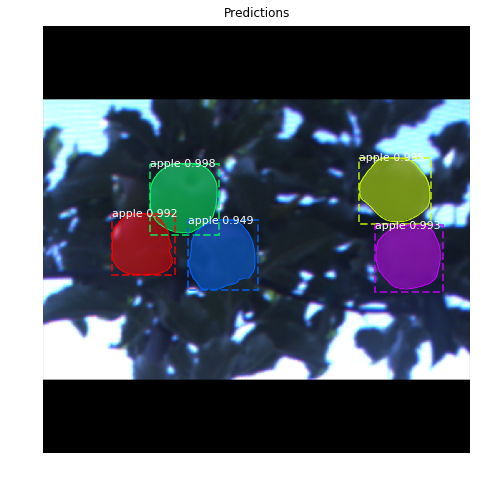

In [0]:
# Run object detection
results = model.detect([original_image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="Predictions")

## Evaluation on Validation Dataset

### Precision-Recall

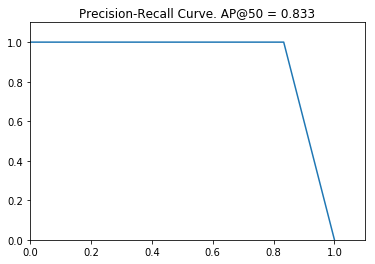

In [0]:
#### Head Training Model, Draw precision-recall curve
AP_head, precisions_head, recalls_head, overlaps_head = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r_head['rois'], r_head['class_ids'], r_head['scores'], r_head['masks'])
visualize.plot_precision_recall(AP_head, precisions_head, recalls_head)

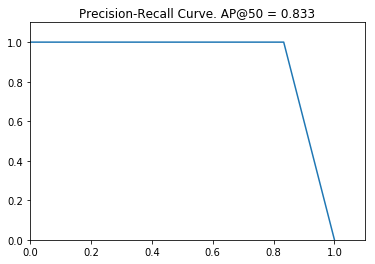

In [0]:
# All Model, Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

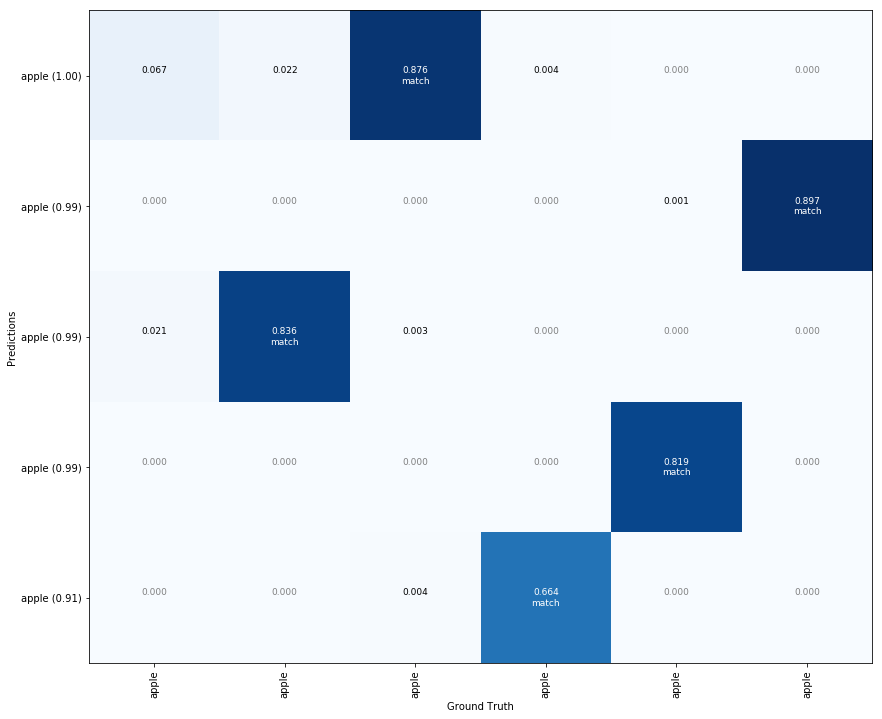

In [0]:
##### Head Training Model, Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r_head['class_ids'], r_head['scores'],
                        overlaps_head, dataset_val.class_names)

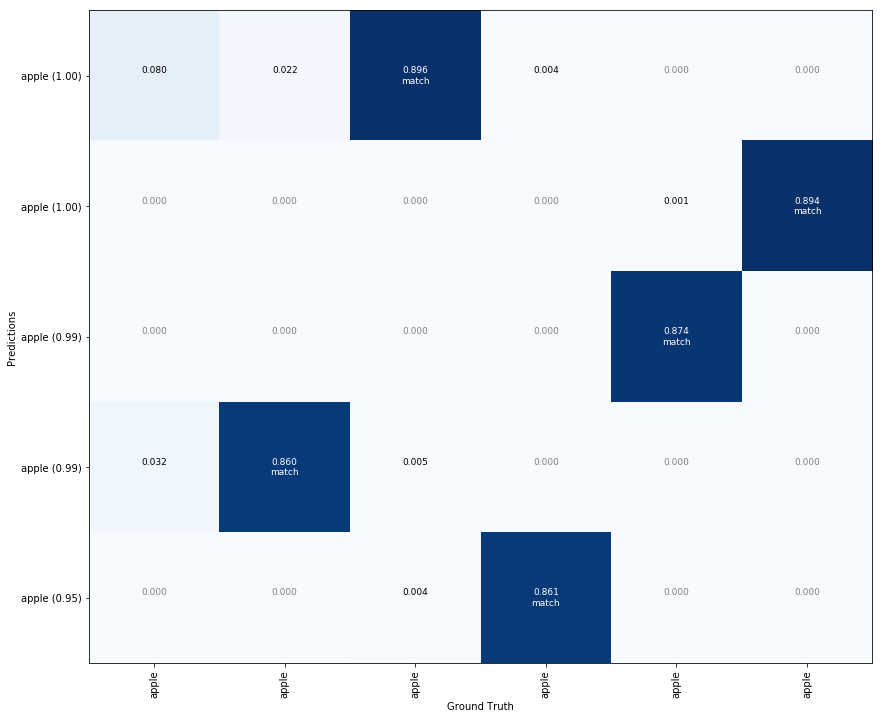

In [0]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset_val.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [0]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids,model,r,dataset):
    t_prediction = 0
    t_start = time.time()
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, inference_config, image_id, use_mini_mask=False)
        # Run object detection
        
        t = time.time()
        results = model.detect([image], verbose=0)
        t_prediction += (time.time() - t)
        
        r = results[0]
        # Compute AP
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
#         print(recalls)
        flag = False
        for data in recalls: 
           if np.isnan(data):
#               print('nan')
              print(image_id,dataset.image_reference(image_id))
              flag= True
              continue
        
        if flag == True: 
            continue
            
        APs.append(AP)
        
    print("Prediction time: {}s. Average {}s/image".format(t_prediction, t_prediction / len(image_ids)))
    print("Total time: {}s ".format(time.time() - t_start))
      
    return APs


In [0]:
#### Head Training Model, choose all validation data
APs = compute_batch_ap(dataset_val.image_ids,model_head,r_head,dataset_val)
print("mAP @ IoU=50: ", np.mean(APs))

/content/drive/My Drive/Mask_RCNN/mrcnn/utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)


7 /content/drive/My Drive/Mask_RCNN/datasets/apples/val/20130320T004413.135503.Cam6_63.png
Prediction time: 56.668505907058716s. Average 0.5059688027415957s/image
Total time: 87.48135542869568s 
mAP @ IoU=50:  0.6929838244273063


In [0]:
APs = compute_batch_ap(dataset_val.image_ids,model,r,dataset_val)
print("mAP @ IoU=50: ", np.mean(APs))

/content/drive/My Drive/Mask_RCNN/mrcnn/utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)


7 /content/drive/My Drive/Mask_RCNN/datasets/apples/val/20130320T004413.135503.Cam6_63.png


/content/drive/My Drive/Mask_RCNN/mrcnn/utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)


14 /content/drive/My Drive/Mask_RCNN/datasets/apples/val/20130320T004424.183355.Cam6_71.png


/content/drive/My Drive/Mask_RCNN/mrcnn/utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)


62 /content/drive/My Drive/Mask_RCNN/datasets/apples/val/20130320T005912.773071.Cam6_52.png
Prediction time: 57.04259514808655s. Average 0.5093088852507728s/image
Total time: 87.35756754875183s 
mAP @ IoU=50:  0.7582708016099884


## Run Detection on Test Dataset

image ID: apple.20130320T005305.337000.Cam6_41.png (43) /content/drive/My Drive/Mask_RCNN/datasets/apples/test/20130320T005305.337000.Cam6_41.png


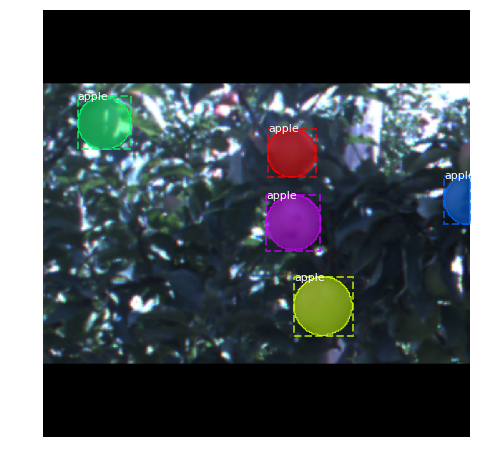

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (5,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (5, 4)                min:   82.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 5)       min:    0.00000  max:    1.00000  bool


In [0]:
image_id2 = random.choice(dataset_test.image_ids)  #43 20130320T005305.337000.Cam6_41.png
image_id2 = 43
# image_id2=28 106 71 27 78 27 #99
original_image2, image_meta2, gt_class_id2, gt_bbox2, gt_mask2 =\
    modellib.load_image_gt(dataset_test, inference_config, image_id2, use_mini_mask=False)
info2 = dataset_test.image_info[image_id2]
print("image ID: {}.{} ({}) {}".format(info2["source"], info2["id"], image_id2, 
                                       dataset_test.image_reference(image_id2)))

# ground truth
visualize.display_instances(original_image2, gt_bbox2, gt_mask2, gt_class_id2, 
                            dataset_test.class_names, figsize=(8, 8))   ######## dataset_train.class_names

log("original_image", original_image2)
log("image_meta", image_meta2)
log("gt_class_id", gt_class_id2)
log("gt_bbox", gt_bbox2)
log("gt_mask", gt_mask2)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


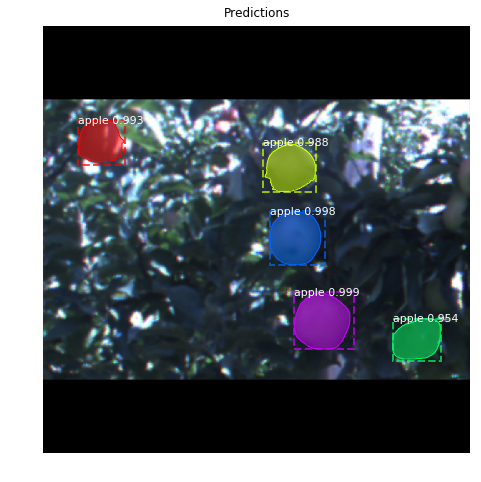

In [0]:
### Head Training Model, Run object detection
results2_head = model_head.detect([original_image2], verbose=1)

# Display results
ax = get_ax(1)
r2_head = results2_head[0]
visualize.display_instances(original_image2, r2_head['rois'], r2_head['masks'], r2_head['class_ids'], 
                            dataset_test.class_names, r2_head['scores'], ax=ax,
                            title="Predictions")

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


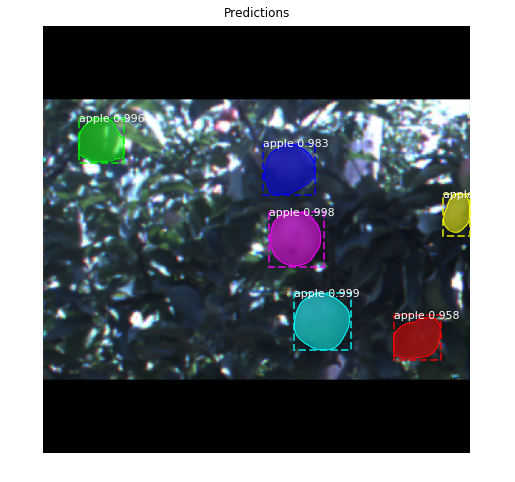

In [0]:
# All Model, Run object detection
results2 = model.detect([original_image2], verbose=1)

# Display results
ax = get_ax(1)
r2= results2[0]
visualize.display_instances(original_image2, r2['rois'], r2['masks'], r2['class_ids'], 
                            dataset_test.class_names, r2['scores'], ax=ax,
                            title="Predictions")

## Evaluation

### Precision-Recall

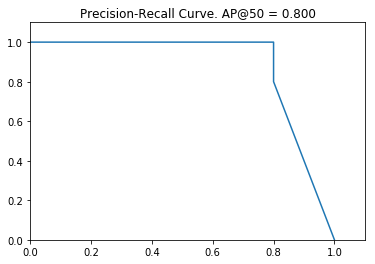

In [0]:
# Draw precision-recall curve
AP2_head, precisions2_head, recalls2_head, overlaps2_head = utils.compute_ap(gt_bbox2, gt_class_id2, gt_mask2,
                                          r2_head['rois'], r2_head['class_ids'], r2_head['scores'], r2_head['masks'])
visualize.plot_precision_recall(AP2_head, precisions2_head, recalls2_head)

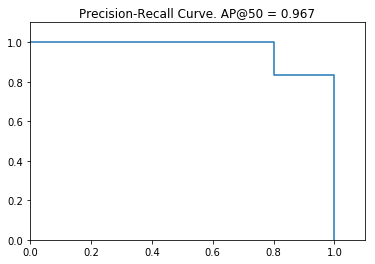

In [0]:
# Draw precision-recall curve
AP2, precisions2, recalls2, overlaps2 = utils.compute_ap(gt_bbox2, gt_class_id2, gt_mask2,
                                          r2['rois'], r2['class_ids'], r2['scores'], r2['masks'])
visualize.plot_precision_recall(AP2, precisions2, recalls2)

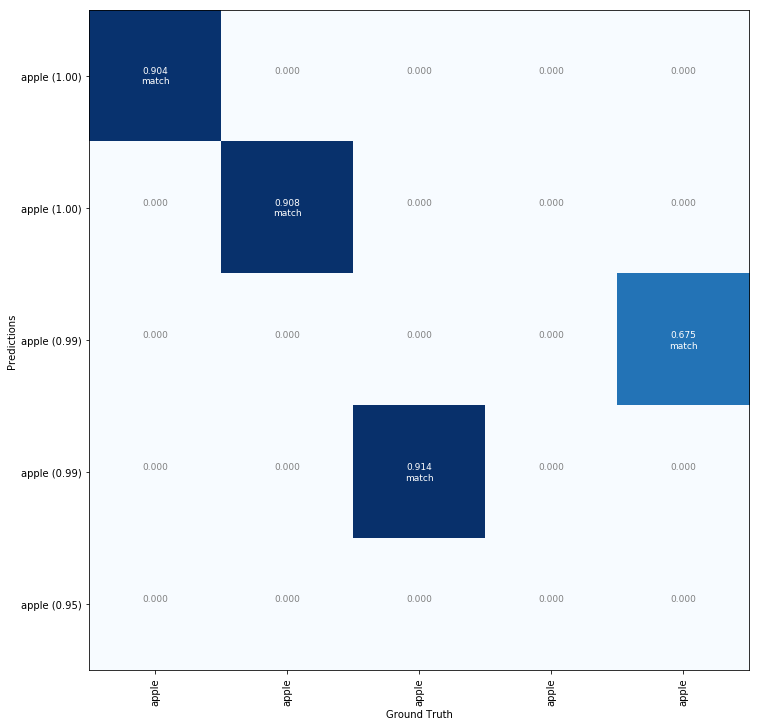

In [0]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id2, r2_head['class_ids'], r2_head['scores'],
                        overlaps2_head, dataset_test.class_names)

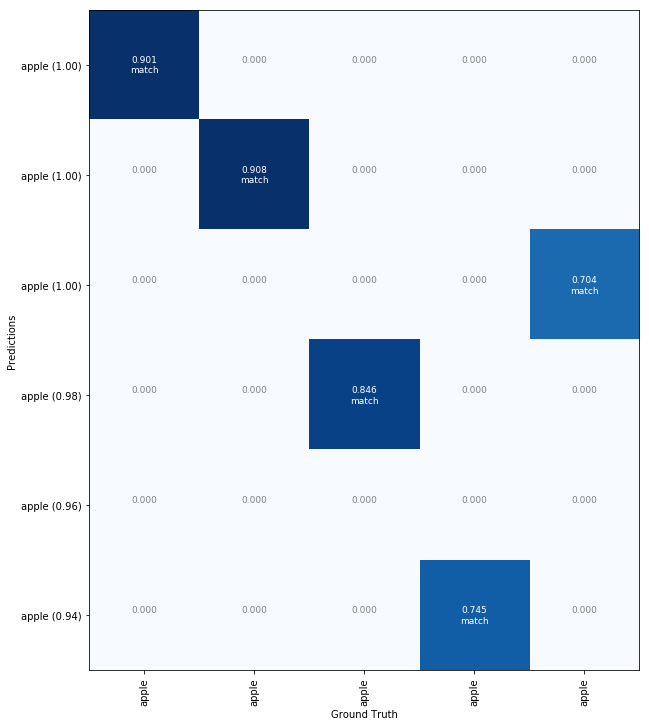

In [0]:
#### Head Training Model, Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id2, r2['class_ids'], r2['scores'],
                        overlaps2, dataset_test.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [0]:
# Head Training Model
# image_ids = np.random.choice(dataset_test.image_ids, 10)
# print(image_ids)
# APs = compute_batch_ap(image_ids,model_head,r2_head)
# print("mAP @ IoU=50: ", np.mean(APs))

In [0]:
# Pick a set of random images
# APs = compute_batch_ap(image_ids,model,r2)
# print("mAP @ IoU=50: ", np.mean(APs))

In [0]:
# Head Training Model
APs_test = compute_batch_ap(dataset_test.image_ids,model_head,r2,dataset_test)
print("mAP @ IoU=50: ", np.mean(APs_test))

/content/drive/My Drive/Mask_RCNN/mrcnn/utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)


7 /content/drive/My Drive/Mask_RCNN/datasets/apples/test/20130320T004351.801805.Cam6_43.png
Prediction time: 57.03900623321533s. Average 0.509276841367994s/image
Total time: 87.01134967803955s 
mAP @ IoU=50:  0.6929838244273063


In [0]:
# All Model
APs_test = compute_batch_ap(dataset_test.image_ids,model,r2,dataset_test)
print("mAP @ IoU=50: ", np.mean(APs_test))

/content/drive/My Drive/Mask_RCNN/mrcnn/utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)


7 /content/drive/My Drive/Mask_RCNN/datasets/apples/test/20130320T004351.801805.Cam6_43.png


/content/drive/My Drive/Mask_RCNN/mrcnn/utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)


14 /content/drive/My Drive/Mask_RCNN/datasets/apples/test/20130320T004528.184672.Cam6_11.png


/content/drive/My Drive/Mask_RCNN/mrcnn/utils.py:734: RuntimeWarning: invalid value encountered in true_divide
  recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)


62 /content/drive/My Drive/Mask_RCNN/datasets/apples/test/20130320T005448.958130.Cam6_63.png
Prediction time: 57.277355670928955s. Average 0.51140496134758s/image
Total time: 87.83061742782593s 
mAP @ IoU=50:  0.7582708016099884


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [0]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
image = original_image   ### test dataset is not correct?
# gt_class_id=gt_class_id  
# gt_bbox=gt_bbox

target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -1.52344  max:    1.75781  float64
positive_anchors         shape: (32, 4)               min:  144.00000  max:  960.00000  float64
negative_anchors         shape: (224, 4)              min: -149.01934  max: 1120.00000  float64
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (32, 4)               min:  162.00000  max:  962.00000  float32


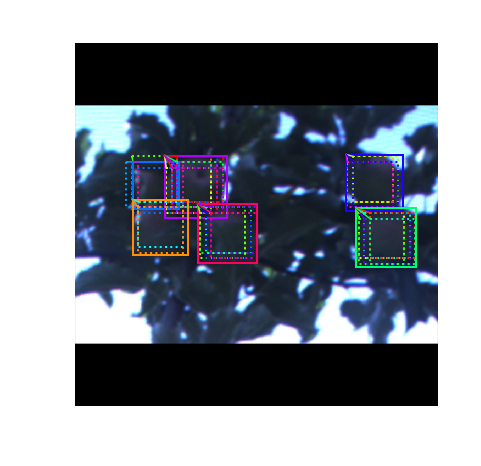

In [0]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [0]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.18768  max:    1.29134  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.15318  max:    1.25376  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (938,)                min:    0.00000  max: 5992.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


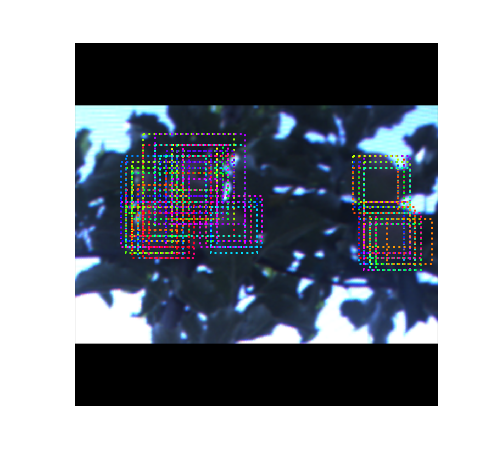

In [0]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

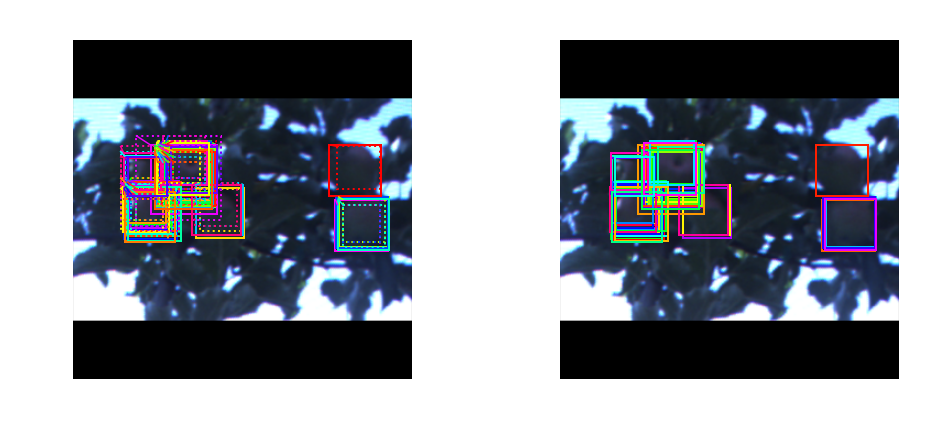

In [0]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

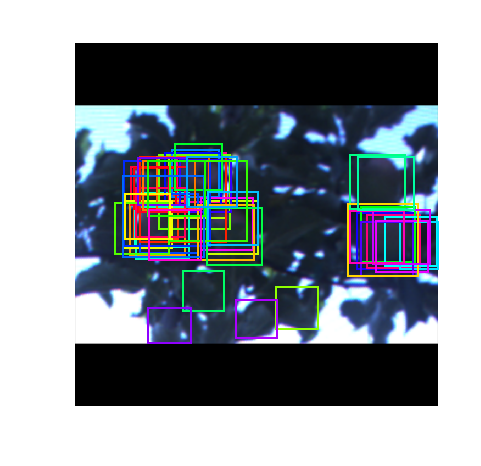

In [0]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

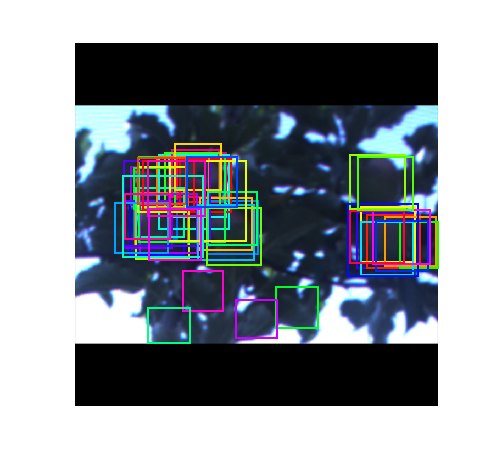

In [0]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = inference_config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [0]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


All Anchors (261888)       Recall: 0.167  Positive anchors: 5
Refined Anchors ( 6000)   Recall: 0.000  Positive anchors: 0
Post NMS Anchors (   50)  Recall: 1.000  Positive anchors: 13


## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [0]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -3.19939  max:    3.07012  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00236  max:    0.99955  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


5 detections: ['apple' 'apple' 'apple' 'apple' 'apple']


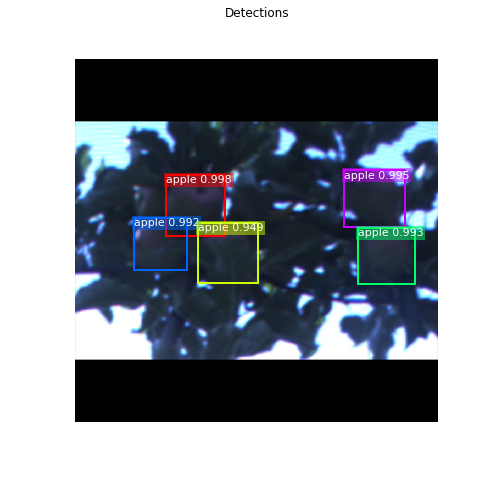

In [0]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_val.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset_val.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

 ### 2.b Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [0]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = inference_config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset_val.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

938 Valid proposals out of 1000
114 Positive ROIs
[('BG', 886), ('apple', 114)]


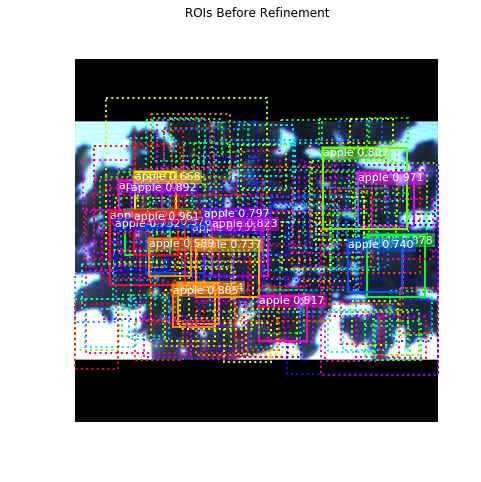

In [0]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -2.54815  max:    2.98074  float32
refined_proposals        shape: (1000, 4)             min:  -59.00000  max: 1023.00000  int32


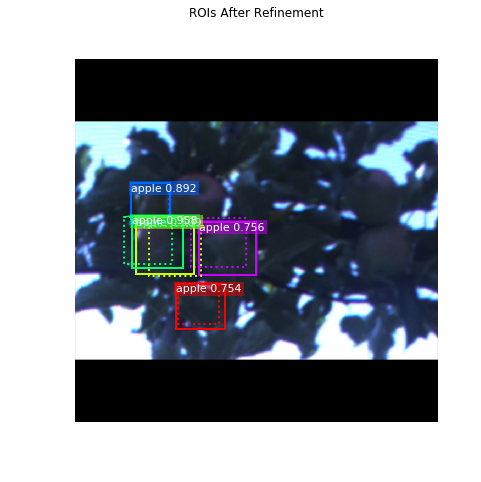

In [0]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * inference_config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [0]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 114 detections:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  21  23  25  26  27  33  34  36  37  38  39  41  42  43  45  48
  49  50  53  54  56  58  59  61  63  67  68  71  74  75  78  79  81  89
  93  94  95  96  98 103 104 106 108 109 115 118 122 123 124 130 131 147
 156 157 158 175 177 187 197 242 245 257 278 289 310 349 397 399 412 426
 435 442 449 450 453 494 499 504 511 519 529 587 612 658 667 764 766 768
 807 856 857 859 871 875]


In [0]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= inference_config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    inference_config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 44:
[  0   1   2   3   4   5   6   9  10  11  13  14  15  16  17  26  33  36
  37  45  48  50  53  58  67  68  71  74  75  78  93  96 104 109 147 156
 412 449 504 658 766 807 856 875]


#### Per-Class Non-Max Suppression

In [0]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            inference_config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset_val.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

apple                 : [  0   1   2   3   4   5   6   9  10  11  13  14  15  16  17  26  33  36
  37  45  48  50  53  58  67  68  71  74  75  78  93  96 104 109 147 156
 412 449 504 658 766 807 856 875] -> [11 10  9  3 33]

Kept after per-class NMS: 5
[ 3  9 10 11 33]


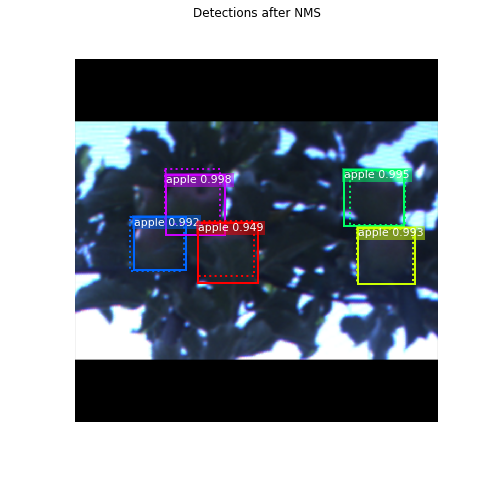

In [0]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

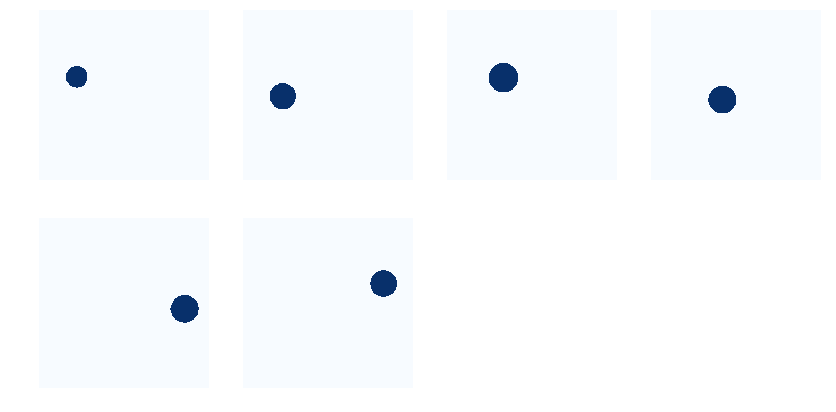

In [0]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [0]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)  ### 只能是4
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_val.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00236  max:    0.99955  float32
5 detections: ['apple' 'apple' 'apple' 'apple' 'apple']


In [0]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (5, 28, 28)           min:    0.00236  max:    0.99955  float32
det_masks                shape: (5, 1024, 1024)       min:    0.00000  max:    1.00000  bool


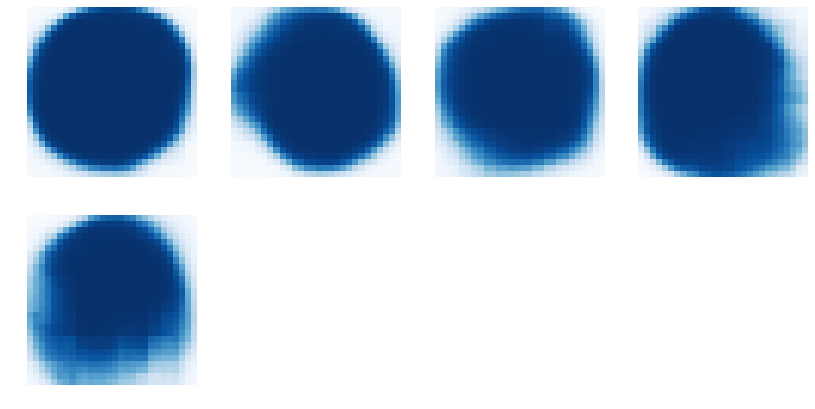

In [0]:
display_images(det_mask_specific[:] * 255, cmap="Blues", interpolation="none")

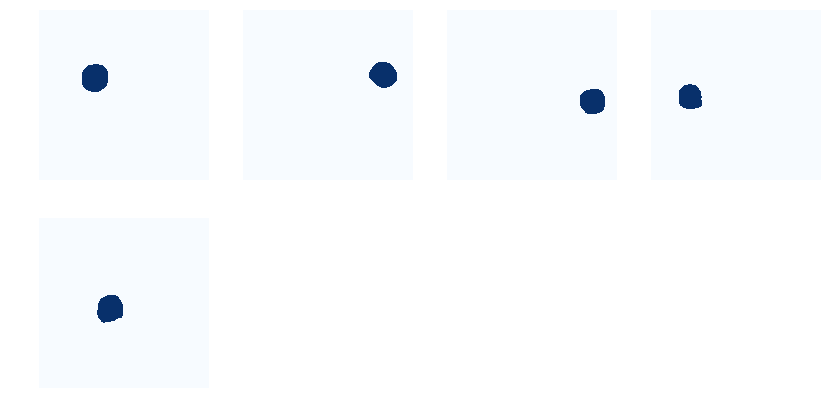

In [0]:
display_images(det_masks[:] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [0]:
# Get activations of a few sample layers
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    # ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   29.58041  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   28.23763  float32
rpn_bbox                 shape: (1, 261888, 4)        min:   -7.16885  max:   30.16777  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


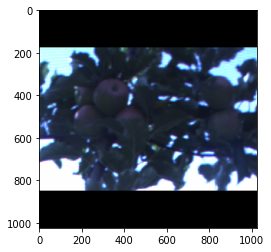

In [0]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],inference_config))

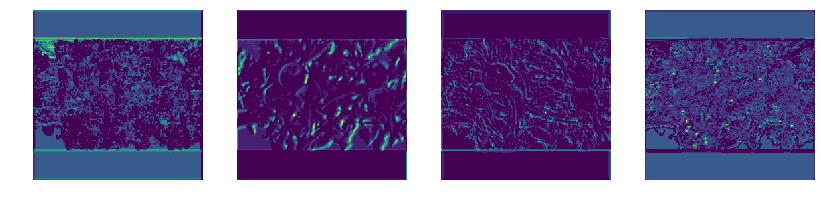

In [0]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

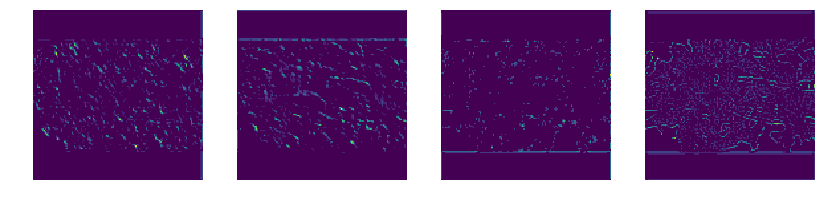

In [0]:
# Backbone feature map
display_images(np.transpose(activations["res3c_out"][0,:,:,:4], [2, 0, 1]))

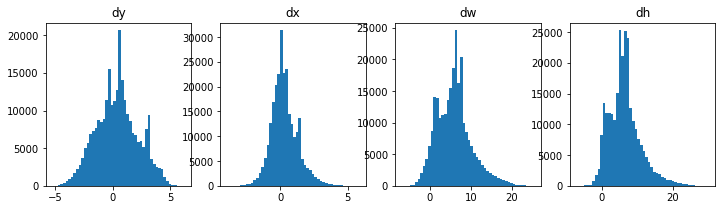

In [0]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

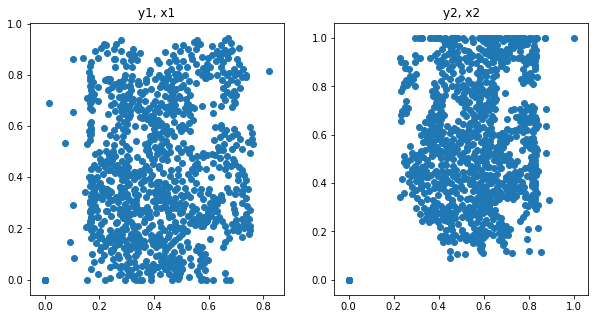

In [0]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()